In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time

In [3]:
device = "mps" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [4]:
def load_data(dir_name: str):
    data = list()
    with open(dir_name, "r") as f:
        [data.append(np.array(line.split(","), dtype=np.float32)) for line in f]
    data = np.asarray(data)
    return data[:,1:], data[:,0] # X, y

In [7]:
X_train, Y_train = load_data("data/mnist_train.csv")
X_test, Y_test = load_data("data/mnist_test.csv")

# rescale 0-255 to 0.0-1.0
X_train = X_train/X_train.max()
X_test = X_test/X_test.max()

# one-hot encoding
y_train = np.zeros((Y_train.size, int(Y_train.max()) + 1))
y_train[np.arange(Y_train.size), Y_train.astype(int)] = 1.0

y_test = np.zeros((Y_test.size, int(Y_test.max()) + 1))
y_test[np.arange(Y_test.size), Y_test.astype(int)] = 1.0

In [8]:
# become one with the data - karpathy
print(f"Training set size: {X_train.shape[0]}x{X_train.shape[1]}")
print(f"Testing set size: {X_test.shape[0]}x{X_test.shape[1]}")

Training set size: 60000x784
Testing set size: 10000x784


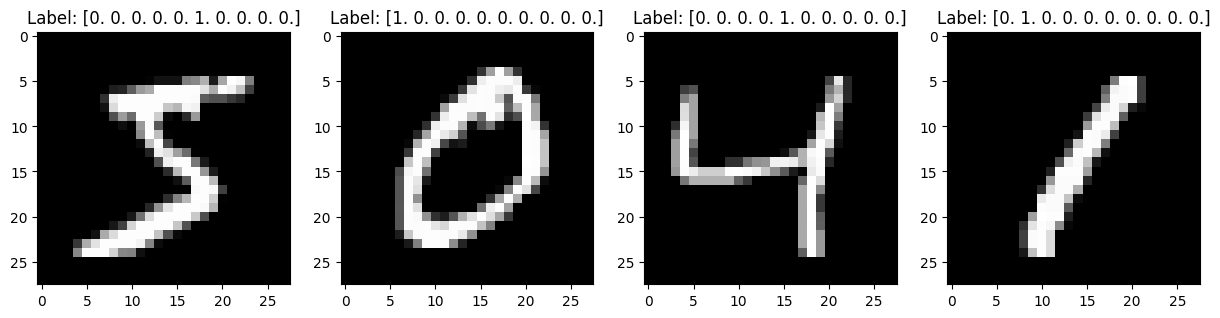

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(15,10))
for image, label, ax in zip(X_train[:4], y_train[:4], axes):
    ax.imshow(image.reshape(28,28), cmap="gray", vmin=0, vmax=1.0)
    ax.set_title(f"Label: {label}")
plt.show()

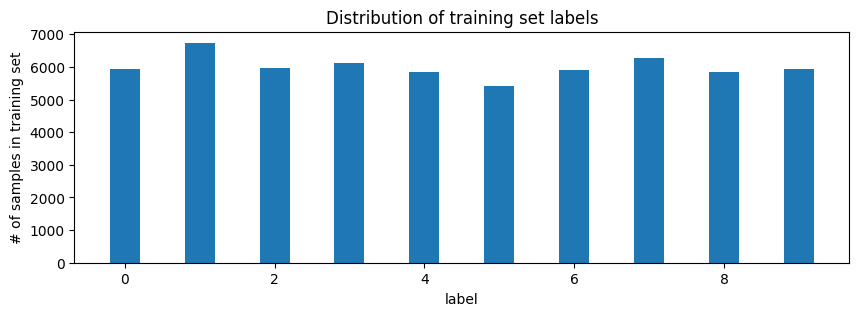

In [10]:
# distribution of labels 0-9
dist = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
for y in Y_train:
    dist[int(y)]+=1

plt.figure(figsize=(10, 3))
plt.bar(dist.keys(), dist.values(), width=0.4, label="Label distribution")
plt.xlabel("label")
plt.ylabel("# of samples in training set")
plt.title("Distribution of training set labels")
plt.show()

In [11]:
class MNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(784, 128)
        self.act1 = nn.ReLU()
        self.output = nn.Linear(128, 10)
        self.act_output = nn.Sigmoid()

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = self.act1(self.h1(X))
        X = self.act_output(self.output(X))
        return X

In [12]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [13]:
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

In [14]:
torch.manual_seed(69)

model = MNIST().to(device)
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 4000
batch_size = 32

losses = []

In [15]:
# do with batching later

optim = torch.optim.Adam(model.parameters(), lr=0.00001)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

start_time = time.time()
for epoch in range(epochs):
    model.train()

    out = model.forward(X_train)

    loss = loss_fn(out, y_train)
    loss_val = loss.to("cpu").detach().numpy()
    losses.append(loss_val)

    optim.zero_grad()
    loss.backward()
    optim.step()

    if epoch % 400 == 0:
        model.eval()
        with torch.inference_mode():
            y_test_pred = model(X_test)
            test_acc = accuracy_fn(y_pred=y_test_pred.argmax(dim=1),
                              y_true=y_test.argmax(dim=1))
        print(f"Epoch: {epoch}, Loss: {loss_val:.2f}, Test accuracy: {test_acc:.2f}%")

end_time = time.time()
total_time = end_time - start_time
print(f"Training completed in {total_time:.1f}s")

Epoch: 0, Loss: 2.30, Test accuracy: 9.64%
Epoch: 400, Loss: 2.21, Test accuracy: 55.13%
Epoch: 800, Loss: 2.11, Test accuracy: 76.45%
Epoch: 1200, Loss: 2.02, Test accuracy: 81.01%
Epoch: 1600, Loss: 1.94, Test accuracy: 82.67%
Epoch: 2000, Loss: 1.88, Test accuracy: 83.84%
Epoch: 2400, Loss: 1.83, Test accuracy: 84.72%
Epoch: 2800, Loss: 1.80, Test accuracy: 85.57%
Epoch: 3200, Loss: 1.76, Test accuracy: 86.20%
Epoch: 3600, Loss: 1.74, Test accuracy: 86.81%
Training completed in 181.8s


In [25]:
y_pred = model(X_test)
acc = accuracy_fn(y_pred=y_pred.argmax(dim=1),
                 y_true=y_test.argmax(dim=1))

print(f"Accuracy: {acc:.2f}%")

Accuracy: 97.66%


In [26]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "MNIST_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/MNIST_model.pth
